In [1]:
import pandas as pd
from data_prep import prepare_data

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from pandarallel import pandarallel
import multiprocessing

num_processors = multiprocessing.cpu_count()
print(f'Available CPUs: {num_processors}')

pandarallel.initialize(nb_workers=num_processors-1, use_memory_fs=False)

Available CPUs: 4
INFO: Pandarallel will run on 3 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [40]:
# df = prepare_data()
df = pd.read_csv("gs://kisai-data-msca310019-capstone/Text_Simplification/raw_data.csv")

In [41]:
df.head()

,source,target,source_level_og,target_level_og,data_source,data_type,source_level_cefr,target_level_cefr,id
0,British people are big tea drinkers. It is a t...,British people love tea. They drink it for dif...,3.0,2.0,BreakingNewsEnglish,text_simplification,NaN,NaN,TS000000001
1,Many people around the world stay at home and ...,Many people stay at home. They do not want to ...,3.0,2.0,BreakingNewsEnglish,text_simplification,NaN,NaN,TS000000002
2,Most of us don't really take much notice of ca...,We rarely notice car license plates. Maybe we ...,3.0,2.0,BreakingNewsEnglish,text_simplification,NaN,NaN,TS000000003
3,Italy's ruling party may introduce a new law t...,Italy wants to stop people using English words...,3.0,2.0,BreakingNewsEnglish,text_simplification,NaN,NaN,TS000000004
4,"Some people are very forgetful, while others c...","Some people are forgetful, while others rememb...",3.0,2.0,BreakingNewsEnglish,text_simplification,NaN,NaN,TS000000005


In [42]:
df.shape

(791159, 9)

In [43]:
df["source"] = df["source"].astype(str)
df["target"] = df["target"].astype(str)

### Data Preparation for Inference

In [44]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
import string
import re

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')


def preprocess_text(text):
    """
    Note: low-income -> low income
    """
    # Convert text to lowercase
    text = text.lower()
    
    # Replace special characters with whitespace
    text = re.sub(r'[^\w\s]', ' ', text)
    
    # Remove leading and trailing whitespace
    text = text.strip()
    
    # Tokenize text into individual words
    words = nltk.word_tokenize(text)
    
    # Remove stopwords from the text
    # stop_words = set(stopwords.words('english'))
    # words = [word for word in words if word not in stop_words]
    
    # Lemmatize the words using WordNetLemmatizer
    # lemmatizer = WordNetLemmatizer()
    # words = [lemmatizer.lemmatize(word) for word in words]
    
    # Perform snowball stemming on the words
    # stemmer = SnowballStemmer("english")
    # words = [stemmer.stem(word) for word in words]
    
    # Join the preprocessed words back into a single string
    preprocessed_text = ' '.join(words)
    
    # Remove leading and trailing whitespace
    preprocessed_text = preprocessed_text.strip()
    
    
    return preprocessed_text

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [45]:
df["source"] = df["source"].parallel_apply(lambda t: preprocess_text(t))
df["target"] = df["target"].parallel_apply(lambda t: preprocess_text(t))

In [46]:
def split_long_texts(df, column_name):
    new_rows = []
    for index, row in df.iterrows():
        text = row[column_name]
        word_count = len(text.split())

        if word_count > 400:
            start = 0
            while start < word_count:
                end = start + 400
                if end > word_count:
                    end = word_count

                sliced_text = ' '.join(text.split()[start:end])
                new_row = row.copy()
                new_row[column_name] = sliced_text
                new_rows.append(new_row)

                start = end

        else:
            new_rows.append(row)

    new_df = pd.DataFrame(new_rows)
    return new_df

In [47]:
# source_df = split_long_texts(df[["id", "source"]], column_name = "source")

In [48]:
df.head()

,source,target,source_level_og,target_level_og,data_source,data_type,source_level_cefr,target_level_cefr,id
0,british people are big tea drinkers it is a tr...,british people love tea they drink it for diff...,3.0,2.0,BreakingNewsEnglish,text_simplification,NaN,NaN,TS000000001
1,many people around the world stay at home and ...,many people stay at home they do not want to g...,3.0,2.0,BreakingNewsEnglish,text_simplification,NaN,NaN,TS000000002
2,most of us don t really take much notice of ca...,we rarely notice car license plates maybe we s...,3.0,2.0,BreakingNewsEnglish,text_simplification,NaN,NaN,TS000000003
3,italy s ruling party may introduce a new law t...,italy wants to stop people using english words...,3.0,2.0,BreakingNewsEnglish,text_simplification,NaN,NaN,TS000000004
4,some people are very forgetful while others ca...,some people are forgetful while others remembe...,3.0,2.0,BreakingNewsEnglish,text_simplification,NaN,NaN,TS000000005


In [49]:
def count_words(t):
    return len(t.split())

df["word_count"] = df["source"].parallel_apply(lambda t: count_words(t))

<AxesSubplot:>

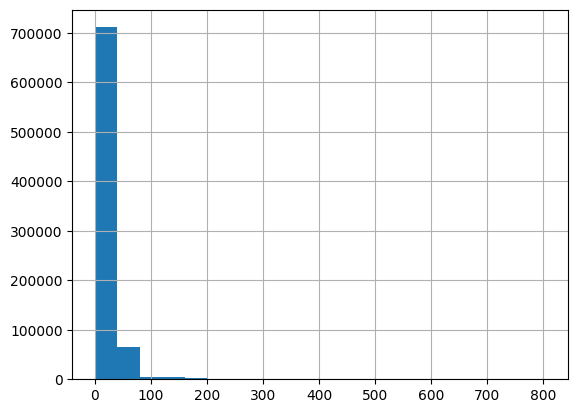

In [50]:
df.word_count.hist(bins=20)

In [51]:
df.describe()

,source_level_og,target_level_og,source_level_cefr,target_level_cefr,word_count
count,12910.000000,12910.000000,0.0,0.0,791159.000000
mean,2.666615,1.333308,NaN,NaN,26.719530
std,0.471441,0.471414,NaN,NaN,33.429554
min,2.000000,1.000000,NaN,NaN,0.000000
25%,2.000000,1.000000,NaN,NaN,15.000000
50%,3.000000,1.000000,NaN,NaN,21.000000
75%,3.000000,2.000000,NaN,NaN,30.000000
max,3.000000,2.000000,NaN,NaN,805.000000


In [52]:
df = df[df.word_count >15]

In [53]:
sample_data = df.sample(frac=1, random_state=42).reset_index(drop=False)

In [54]:
len(sample_data)

582443

In [55]:
import math
sample_fraction = .1

end_limit = math.ceil(len(sample_data)*sample_fraction)

In [56]:
sample_data = sample_data.iloc[:end_limit]
len(sample_data)

58245

In [57]:
sample_data

,index,source,target,source_level_og,target_level_og,data_source,data_type,source_level_cefr,target_level_cefr,id,word_count
0,452955,he is most famous for scoring the golden goal ...,total number 4 number 5,NaN,NaN,WikiLarge,text_simplification,NaN,NaN,TS000452964,31
1,679682,gumbasia lrb available in 2 video formats rrb ...,gumbasia lrb available in 2 video formats rrb ...,NaN,NaN,WikiSmall,text_simplification,NaN,NaN,TS000679691,25
2,246154,john bull lrb 1562 or 1563 â 15 march 1628 rrb...,john bull lrb born 1562 or 1563 died march 15 ...,NaN,NaN,WikiLarge,text_simplification,NaN,NaN,TS000246163,19
3,208482,after a welcoming speech by edward the prince ...,he said the queen declares this hall is now open,NaN,NaN,WikiLarge,text_simplification,NaN,NaN,TS000208491,32
4,415651,his anti fascist political views caused him a ...,his political ideas gave him a great deal of t...,NaN,NaN,WikiLarge,text_simplification,NaN,NaN,TS000415660,18
...,...,...,...,...,...,...,...,...,...,...,...
58240,427503,person 1 cbe lrb born number 1 may number 2 in...,person 1 lrb born number 1 may number 2 in loc...,NaN,NaN,WikiLarge,text_simplification,NaN,NaN,TS000427512,23
58241,342136,situated at the confluence of the location 1 a...,location 1 is a city in location 3 location 4 ...,NaN,NaN,WikiLarge,text_simplification,NaN,NaN,TS000342145,29
58242,687198,since the mid 1990s a number of wine brands ha...,top quality corks are quite expensive so many ...,NaN,NaN,WikiSmall,text_simplification,NaN,NaN,TS000687207,24
58243,743925,third form person 1 s third formdragon ball z ...,third form person 1 s third form is again more...,NaN,NaN,WikiSmall,text_simplification,NaN,NaN,TS000743934,25


### Downloading the Model

In [64]:
BUCKET_NAME = "kisai-data-msca310019-capstone"

MODEL_BLOB_NAME = "CEFR/models/cefr_ktrain_bert/tf_model.h5"
MODEL_FILE_NAME = "./model/tf_model.h5"

PREPROC_BLOB_NAME = "CEFR/models/cefr_ktrain_bert/tf_model.preproc"
PREPROC_FILE_NAME = "./model/tf_model.preproc"

model_load_path = "gs://kisai-data-msca310019-capstone/CEFR/models/cefr_ktrain_bert/"

In [16]:
from google.cloud import storage

def download_blob(bucket_name, source_blob_name, destination_file_name):
    """Downloads a blob from COS bucket."""
    gcs_client = storage.Client()
    bucket = gcs_client.bucket(bucket_name)
    blob = bucket.blob(source_blob_name)
    blob.download_to_filename(destination_file_name)

In [18]:
%ls -al

total 1282340
drwxr-xr-x 4 jupyter jupyter       4096 May 17 21:05 ./
drwxr-xr-x 6 jupyter jupyter       4096 May 17 20:14 ../
drwxr-xr-x 2 jupyter jupyter       4096 May 17 20:21 .ipynb_checkpoints/
drwxr-xr-x 2 jupyter jupyter       4096 May 17 20:53 __pycache__/
-rw-r--r-- 1 jupyter jupyter      12225 May 17 20:48 data_prep.py
-rw-r--r-- 1 jupyter jupyter      15729 May 17 21:05 predict_cefr_label.ipynb
-rw-r--r-- 1 jupyter jupyter 1313066856 May 17 21:06 tf_model.h5


In [21]:
download_blob(bucket_name = BUCKET_NAME, 
              source_blob_name = MODEL_BLOB_NAME, 
              destination_file_name = MODEL_FILE_NAME)

In [22]:
download_blob(bucket_name = BUCKET_NAME, 
              source_blob_name = PREPROC_BLOB_NAME, 
              destination_file_name = PREPROC_FILE_NAME)

### Inference

In [11]:
import ktrain

In [12]:
predictor = ktrain.load_predictor("model")

In [58]:
source_labels = predictor.predict(list(sample_data["source"]))

1821/1821 [==============================] - 1663s 913ms/step


In [59]:
target_labels = predictor.predict(list(sample_data["target"]))

1821/1821 [==============================] - 1661s 912ms/step


In [65]:
sample_data["source_level_cefr"] = [label.split("_")[1] for label in source_labels]

In [67]:
sample_data["target_level_cefr"] = [label.split("_")[1] for label in target_labels]

In [68]:
sample_data

,index,source,target,source_level_og,target_level_og,data_source,data_type,source_level_cefr,target_level_cefr,id,word_count
0,452955,he is most famous for scoring the golden goal ...,total number 4 number 5,NaN,NaN,WikiLarge,text_simplification,2,0,TS000452964,31
1,679682,gumbasia lrb available in 2 video formats rrb ...,gumbasia lrb available in 2 video formats rrb ...,NaN,NaN,WikiSmall,text_simplification,1,1,TS000679691,25
2,246154,john bull lrb 1562 or 1563 â 15 march 1628 rrb...,john bull lrb born 1562 or 1563 died march 15 ...,NaN,NaN,WikiLarge,text_simplification,1,1,TS000246163,19
3,208482,after a welcoming speech by edward the prince ...,he said the queen declares this hall is now open,NaN,NaN,WikiLarge,text_simplification,1,0,TS000208491,32
4,415651,his anti fascist political views caused him a ...,his political ideas gave him a great deal of t...,NaN,NaN,WikiLarge,text_simplification,1,1,TS000415660,18
...,...,...,...,...,...,...,...,...,...,...,...
58240,427503,person 1 cbe lrb born number 1 may number 2 in...,person 1 lrb born number 1 may number 2 in loc...,NaN,NaN,WikiLarge,text_simplification,0,0,TS000427512,23
58241,342136,situated at the confluence of the location 1 a...,location 1 is a city in location 3 location 4 ...,NaN,NaN,WikiLarge,text_simplification,2,0,TS000342145,29
58242,687198,since the mid 1990s a number of wine brands ha...,top quality corks are quite expensive so many ...,NaN,NaN,WikiSmall,text_simplification,2,1,TS000687207,24
58243,743925,third form person 1 s third formdragon ball z ...,third form person 1 s third form is again more...,NaN,NaN,WikiSmall,text_simplification,2,1,TS000743934,25


In [69]:
sample_data.to_csv("gs://kisai-data-msca310019-capstone/Text_Simplification/cefr_labeled_sample.csv", index=False)

In [64]:
df = pd.read_csv("gs://kisai-data-msca310019-capstone/Text_Simplification/cefr_labeled_sample.csv")
df.head()

,index,source,target,source_level_og,target_level_og,data_source,data_type,source_level_cefr,target_level_cefr,id,word_count
0,452955,he is most famous for scoring the golden goal ...,total number 4 number 5,NaN,NaN,WikiLarge,text_simplification,label_2,label_0,TS000452964,31
1,679682,gumbasia lrb available in 2 video formats rrb ...,gumbasia lrb available in 2 video formats rrb ...,NaN,NaN,WikiSmall,text_simplification,label_1,label_1,TS000679691,25
2,246154,john bull lrb 1562 or 1563 â 15 march 1628 rrb...,john bull lrb born 1562 or 1563 died march 15 ...,NaN,NaN,WikiLarge,text_simplification,label_1,label_1,TS000246163,19
3,208482,after a welcoming speech by edward the prince ...,he said the queen declares this hall is now open,NaN,NaN,WikiLarge,text_simplification,label_1,label_0,TS000208491,32
4,415651,his anti fascist political views caused him a ...,his political ideas gave him a great deal of t...,NaN,NaN,WikiLarge,text_simplification,label_1,label_1,TS000415660,18
